In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import tensorflow as tf 
import os 
from PIL import Image
import cv2 as cv 

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.preprocessing import image
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import img_to_array
from keras.applications.resnet_v2 import ResNet50V2, decode_predictions, preprocess_input

In [4]:
np.random.seed(42)

In [5]:
cat_train = 'training_set/training_set/cats'

cat_test = 'test_set/test_set/cats/'

dog_train = 'training_set/training_set/dogs/'

dog_test = 'test_set/test_set/dogs/'


train_data = 'training_set/training_set/'
test_data = 'test_set/test_set/'

In [6]:
print("Total cats for training = ", len(os.listdir(cat_train)))
print("Total cats for testing = ", len(os.listdir(cat_test)))
print("Total dogs for training = ", len(os.listdir(dog_train)))
print("Total dogs for testing = ", len(os.listdir(dog_test)))


Total cats for training =  4000
Total cats for testing =  1011
Total dogs for training =  4005
Total dogs for testing =  1012


# Set pre-trained model weights and input shape

In [7]:
resnet = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224,224,3))
for layer in resnet.layers:
    layer.trainable = False

## Converting image to executable data using ImageDataGenerator

In [8]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
)

In [9]:
target = (224,224)
batch = 16
epochs = 5

## Train, Validation and Test Data

In [10]:
train_generator = train_datagen.flow_from_directory(
    directory=train_data,
    target_size=target,
    batch_size=batch,
    class_mode='binary',
    subset='training'
)


validation_generator = train_datagen.flow_from_directory(
    directory=train_data,
    target_size=target,
    batch_size=batch,
    class_mode='binary',
    subset='validation'
)



test_generator = test_datagen.flow_from_directory(
    directory=test_data,
    target_size=target,
    batch_size=batch,
    class_mode='binary'
)

Found 6404 images belonging to 2 classes.
Found 1601 images belonging to 2 classes.
Found 2023 images belonging to 2 classes.


# Adding ResNet to custom model with custom output

In [11]:
x = resnet.output
x = GlobalAveragePooling2D()(x) 
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=resnet.input, outputs=predictions)

In [12]:
model.compile(optimizer=RMSprop(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [13]:
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator
)

Epoch 1/5
401/401 [==============================] - 257s 601ms/step - loss: 0.1611 - accuracy: 0.9369 - val_loss: 0.1232 - val_accuracy: 0.9638
Epoch 2/5
401/401 [==============================] - 206s 514ms/step - loss: 0.1047 - accuracy: 0.9666 - val_loss: 0.0741 - val_accuracy: 0.9694
Epoch 3/5
401/401 [==============================] - 208s 517ms/step - loss: 0.0951 - accuracy: 0.9646 - val_loss: 0.0856 - val_accuracy: 0.9719
Epoch 4/5
401/401 [==============================] - 208s 518ms/step - loss: 0.0844 - accuracy: 0.9716 - val_loss: 0.0792 - val_accuracy: 0.9713
Epoch 5/5
401/401 [==============================] - 207s 516ms/step - loss: 0.0917 - accuracy: 0.9683 - val_loss: 0.0789 - val_accuracy: 0.9688


### Train Validation Plot

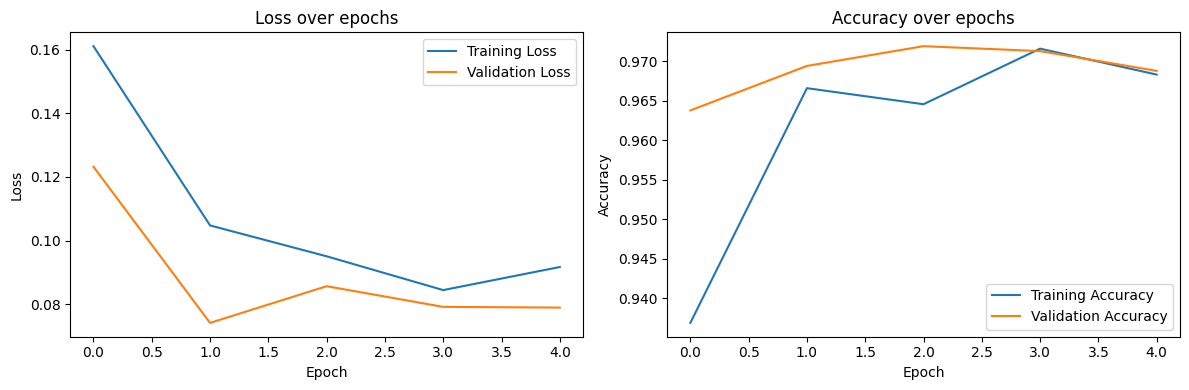

In [14]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')


plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

# Evaluating on unseen data

In [15]:
loss, accuracy = model.evaluate(test_generator)
print("Test Evaluation")
print(f"Loss:{loss}\nAccuracy:{accuracy}")

127/127 [==============================] - 54s 427ms/step - loss: 0.0639 - accuracy: 0.9807
Test Evaluation
Loss:0.06389615684747696
Accuracy:0.9807217121124268


### Predicting on new dataset

1/1 [==============================] - 0s 34ms/step


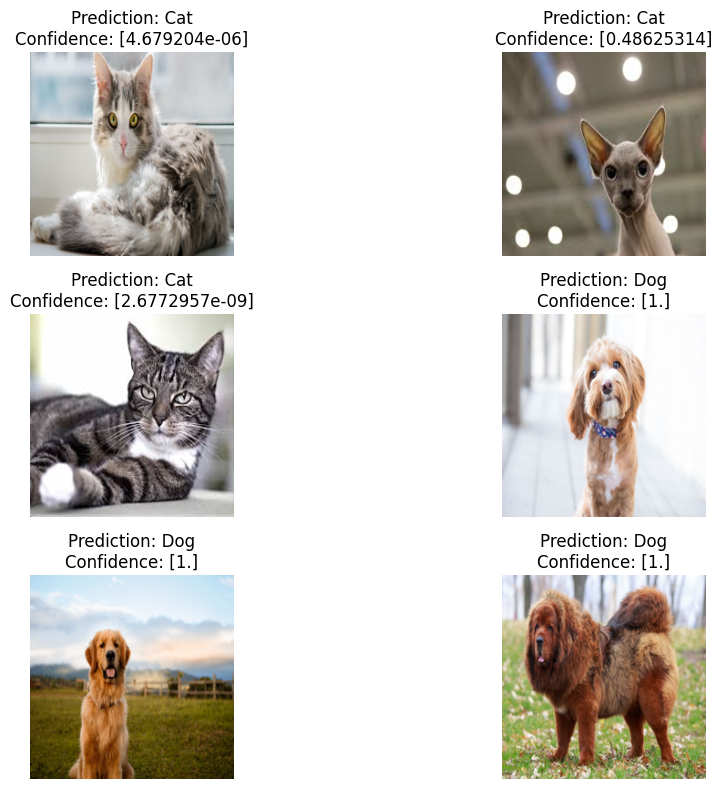

In [16]:
test_images_dir = "cats and dogs/"
test_files = [file for file in os.listdir(test_images_dir) if file.endswith('.jpg')]

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 8))

for i, image_path in enumerate(test_files):
    # Load and preprocess the image
    img = Image.open(os.path.join(test_images_dir, image_path))
    img = img.resize((224, 224))  # Resize the image
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalize the image

    # Make predictions
    evaluation = model.evaluate(img_array)
    predictions = model.predict(img_array)
    
    # Determine class label
    class_label = "Cat" if predictions[0] < 0.5 else "Dog"

    # Plot the image
    row = i // 2
    col = i % 2
    axes[row, col].imshow(img)
    axes[row, col].axis('off')
    axes[row, col].set_title(f"Prediction: {class_label}\nConfidence: {predictions[0]}")

plt.tight_layout()
plt.show()

##### Model Summary

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [18]:
model.save("classifier.h5")

In [19]:
a = tf.keras.models.load_model("classifier.h5")